# Scientific Python
## Central European University // Fall 2021

## Final Project
Instructor: Marton Posfai

Student: Alessandra Oshiro


## 1. Introduction

In this project, my aim is twofold. First, I will explore the "Mass Mobilization Data" dataset in look for interesting trends and patterns across regions. Second, I will try to build a machine learning model using logistic regression for binary classification. With this, I want to see if it is possible to predict the state response based on the mobilization's demands, duration, and use of violence by the protesters. 

As mentioned before, this project is based on the "Mass Mobilization Data" dataset, which was elaborated by David Clark and Reagan Patrick. Made publicly available in 2016, it contains data of mass mobilizations (i.e., protests with at least 50 participants) ocurred between 1990 and 2014, in 162 different countries. I will provide more details about relevant variables in latter stages of the project. Nevertheless, the codebook and the dataset can be accessed through the following link: https://doi.org/10.7910/DVN/HTTWYL/TJJZNG. 

## 2. Loading And Cleaning The Dataset


In this section, I prepared the data for the exploration and machine learning sections that come later. This process included dealing with NaNs, deciding which variables are useful for the project, renaming the variables so that they are more informative, among other things. Each part of the data cleaning process is explained in more detail before the corresponding code. 


First, I imported the required modules.


In [529]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, linear_model, metrics

Then, I loaded the data and used the "head" function to have a better idea of how the dataset looks like. The use of the "info" function serves the same purpose, as it provides useful information about the NaNs and object types in each variable. 

In [565]:
social_movements_df = pd.read_csv("social_movements.csv")
social_movements_df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
0,201990001,Canada,20,1990,North America,1,1,15.0,1.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...
1,201990002,Canada,20,1990,North America,1,2,25.0,6.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...
2,201990003,Canada,20,1990,North America,1,3,1.0,7.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai..."
3,201990004,Canada,20,1990,North America,1,4,12.0,7.0,1990.0,...,NaN,accomodation,NaN,NaN,NaN,NaN,NaN,NaN,1. indians gather as siege intensifies; armed ...,canada s federal government has agreed to acqu...
4,201990005,Canada,20,1990,North America,1,5,14.0,8.0,1990.0,...,NaN,crowd dispersal,arrests,accomodation,NaN,NaN,NaN,NaN,1. dozens hurt in mohawk blockade protest the ...,protests were directed against the state due t...


In [566]:
social_movements_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17145 entries, 0 to 17144
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     17145 non-null  int64  
 1   country                17145 non-null  object 
 2   ccode                  17145 non-null  int64  
 3   year                   17145 non-null  int64  
 4   region                 17145 non-null  object 
 5   protest                17145 non-null  int64  
 6   protestnumber          17145 non-null  int64  
 7   startday               15239 non-null  float64
 8   startmonth             15239 non-null  float64
 9   startyear              15239 non-null  float64
 10  endday                 15239 non-null  float64
 11  endmonth               15239 non-null  float64
 12  endyear                15239 non-null  float64
 13  protesterviolence      15758 non-null  float64
 14  location               15218 non-null  object 
 15  pa

With a better picture of the dataset, I started the data cleaning process. First, I dropped the columns that were not necessary for the analysis. These variables were either redundant, irrelevant, or were coded in a way that made it difficult to process and recode for the machine learning model.

In [567]:
social_movements_df.drop(["id", "ccode", "protesteridentity", "participants_category", "location", "sources", "notes", "protestnumber", "participants"], 
                            axis = 1, inplace = True)

Another thing to consider during the cleaning is the amount of NaNs. As the initial summary indicates, there are several variables that have a noticeable amount of missing values. To have a better picture of this, I calculated the proportion of NaNs per column.

In [568]:
column_na_proportion = social_movements_df.isna().sum()/len(social_movements_df)
print(column_na_proportion)

country              0.000000
year                 0.000000
region               0.000000
protest              0.000000
startday             0.111169
startmonth           0.111169
startyear            0.111169
endday               0.111169
endmonth             0.111169
endyear              0.111169
protesterviolence    0.080898
protesterdemand1     0.111228
protesterdemand2     0.826363
protesterdemand3     0.977661
protesterdemand4     0.951531
stateresponse1       0.112978
stateresponse2       0.831554
stateresponse3       0.945757
stateresponse4       0.985768
stateresponse5       0.950481
stateresponse6       0.999067
stateresponse7       0.946340
dtype: float64


As mentioned in the introduction, my interest in this project is to explore trends in mass mobilizations and try to predict how states respond to them. The calculation for the NaNs proportion shows that some of the variables for state response and protester demands are mostly filled with missing values. However, fortunately, this is only the cases in which the mobilization had more than one demand or the state had more than one response. Because of this, I decided to restrict the sample only to the cases in which the mobilization had one demand and the state had one response to it. The following section deals with the cleaning of NaNs in the variables which are important for the attempt of predicting the state response (i.e., "stateresponse", "protesterdemand", and "protesterviolence"). 

In [569]:
social_movements_df.dropna(subset = ["stateresponse1", "protesterdemand1", "protesterviolence"], inplace = True)

In [570]:
column_na_proportion = social_movements_df.isna().sum()/len(social_movements_df)
print(column_na_proportion)

country              0.000000
year                 0.000000
region               0.000000
protest              0.000000
startday             0.000000
startmonth           0.000000
startyear            0.000000
endday               0.000000
endmonth             0.000000
endyear              0.000000
protesterviolence    0.000000
protesterdemand1     0.000000
protesterdemand2     0.804971
protesterdemand3     0.974882
protesterdemand4     0.948777
stateresponse1       0.000000
stateresponse2       0.810231
stateresponse3       0.938848
stateresponse4       0.983956
stateresponse5       0.947593
stateresponse6       0.998948
stateresponse7       0.943648
dtype: float64


Fortunately, dropping the NaNs for the important variables mentioned above led to a removal of missing values in most of the other variables. However, the variables for additional protester demands and state responses were still high. As clarified before, I decided to restrict the sample only to the cases which show one demand and one response. I opted for this instead of straightforwardly dropping the additional variables because the dataset does not specify if the demands and responses are ordered according to importance or temporal sequence. Therefore, keeping the first demand and the first response of every case regardless of there being additional demands or responses would give us unaccurate information.

The following code filters the dataset so that it includes only the cases in which there was only one demand and once response. It then drops the columns with additional demands or response data. Finally, it drops any additional NaN value. 

In [571]:
social_movements_df = social_movements_df[social_movements_df["stateresponse2"].isna()]
social_movements_df = social_movements_df[social_movements_df["protesterdemand2"].isna()]

In [572]:
social_movements_df.drop(
    ["protesterdemand2", "protesterdemand3", "protesterdemand4", 
    "stateresponse2", "stateresponse3", "stateresponse4", 
    "stateresponse5", "stateresponse6", "stateresponse7"], axis = 1, inplace=True)

social_movements_df = social_movements_df.dropna()

Having cleaned the missing values and the unnecessary columns, I added adequate variables for the logistic regression. First, the variable for protester demands ("protesterdemands1") was used to create the variable "demand_is_economic". This is coded 1 for the mass mobilizations which were motivated by economic concerns (labor wage dispute, land farm issue, and price increases/tax policy) and 0 when they were motivated by political or social issues (police brutality, removal of politician, political behavior or processes, and social restrictions). 

The same was done for the variable for state response ("stateresponse1"). In this case, the new variable indicates whether the state made use of force in its response to the mobilization. Therefore, it is coded 1 for forceful responses (crowd dispersion, arrest, shooting, and killing) and 0 for pacific responses (ignore, or accomodation). This is stored under the "response_use_force" variable. 

In [573]:
demands_mask = social_movements_df["protesterdemand1"].isin(["labor wage dispute", "land farm issue", "price increases, tax policy"])
social_movements_df["demand_is_economic"] = np.where(demands_mask, 1, 0)

response_mask = social_movements_df["stateresponse1"].isin(["ignore", "accomodation"])
social_movements_df["response_use_force"] = np.where(response_mask, 0, 1)

social_movements_df.head()

,country,year,region,protest,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,protesterdemand1,stateresponse1,demand_is_economic,response_use_force
1,Canada,1990,North America,1,25.0,6.0,1990.0,25.0,6.0,1990.0,0.0,"political behavior, process",ignore,0,0
2,Canada,1990,North America,1,1.0,7.0,1990.0,1.0,7.0,1990.0,0.0,"political behavior, process",ignore,0,0
3,Canada,1990,North America,1,12.0,7.0,1990.0,6.0,9.0,1990.0,1.0,land farm issue,accomodation,1,0
6,Canada,1991,North America,1,10.0,9.0,1991.0,17.0,9.0,1991.0,0.0,labor wage dispute,ignore,1,0
7,Canada,1991,North America,1,28.0,9.0,1991.0,2.0,10.0,1991.0,0.0,labor wage dispute,ignore,1,0


In addition to those two new variables, the data about the start and end of the mobilizations also needed formatting. The original dataset had the year, the month, and the date in three different columns. Using those, I converted the start date and the end date of each mobilization to a single datetime object. This made it easier to calculate the duration of each mobilization. The following code does the transformation to the datetime object and then adds them under the "start_date" and "end_date" variables. The duration of each mobilization was also calculated and added under the "mobilization_duration" variable. 

In [574]:
social_movements_startdate = social_movements_df[["startday", "startmonth", "startyear"]].astype(int).copy()
social_movements_startdate.columns = ["day", "month", "year"]
social_movements_df["start_date"] = pd.to_datetime(social_movements_startdate)

social_movements_enddate = social_movements_df[["endday", "endmonth", "endyear"]].astype(int).copy()
social_movements_enddate.columns = ["day", "month", "year"]
social_movements_df["end_date"] = pd.to_datetime(social_movements_enddate)

social_movements_df.head()


,country,year,region,protest,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,protesterdemand1,stateresponse1,demand_is_economic,response_use_force,start_date,end_date
1,Canada,1990,North America,1,25.0,6.0,1990.0,25.0,6.0,1990.0,0.0,"political behavior, process",ignore,0,0,1990-06-25,1990-06-25
2,Canada,1990,North America,1,1.0,7.0,1990.0,1.0,7.0,1990.0,0.0,"political behavior, process",ignore,0,0,1990-07-01,1990-07-01
3,Canada,1990,North America,1,12.0,7.0,1990.0,6.0,9.0,1990.0,1.0,land farm issue,accomodation,1,0,1990-07-12,1990-09-06
6,Canada,1991,North America,1,10.0,9.0,1991.0,17.0,9.0,1991.0,0.0,labor wage dispute,ignore,1,0,1991-09-10,1991-09-17
7,Canada,1991,North America,1,28.0,9.0,1991.0,2.0,10.0,1991.0,0.0,labor wage dispute,ignore,1,0,1991-09-28,1991-10-02


In [575]:
social_movements_df = social_movements_df.reset_index(drop=True)
mobilization_duration = [(social_movements_df["end_date"][i] - social_movements_df["start_date"][i]).days for i in range(len(social_movements_df))]
social_movements_df["mobilization_duration"] = mobilization_duration


Then, for it to be uniform, I converted the floats in "protesterviolence" to integers. 

In [578]:
protester_violence_int = [int(social_movements_df["protesterviolence"][i]) for i in range(len(social_movements_df))]
social_movements_df["protesterviolence"] = protester_violence_int

Finally, I renamed and reordered the columns.

In [579]:
social_movements_df = social_movements_df[["country", "year", "region", "start_date", "end_date", "mobilization_duration", "protest", "protesterviolence", "protesterdemand1", "demand_is_economic", "stateresponse1", "response_use_force"]]
social_movements_df.columns = ["country", "year", "region", "start_date", "end_date", "mobilization_duration", "protest", "protester_violence", "protester_demand", "economic_demand", "state_response", "response_use_force"]

In [580]:
social_movements_df.head(20)

,country,year,region,start_date,end_date,mobilization_duration,protest,protester_violence,protester_demand,economic_demand,state_response,response_use_force
0,Canada,1990,North America,1990-06-25,1990-06-25,0,1,0,"political behavior, process",0,ignore,0
1,Canada,1990,North America,1990-07-01,1990-07-01,0,1,0,"political behavior, process",0,ignore,0
2,Canada,1990,North America,1990-07-12,1990-09-06,56,1,1,land farm issue,1,accomodation,0
3,Canada,1991,North America,1991-09-10,1991-09-17,7,1,0,labor wage dispute,1,ignore,0
4,Canada,1991,North America,1991-09-28,1991-10-02,4,1,0,labor wage dispute,1,ignore,0
5,Canada,1992,North America,1992-05-04,1992-05-05,1,1,1,police brutality,0,arrests,1
6,Canada,1993,North America,1993-05-16,1993-05-16,0,1,0,"political behavior, process",0,ignore,0
7,Canada,1993,North America,1993-07-01,1993-08-31,61,1,0,"political behavior, process",0,arrests,1
8,Canada,1994,North America,1994-09-01,1994-09-01,0,1,0,"political behavior, process",0,ignore,0
9,Canada,1994,North America,1994-11-18,1994-11-18,0,1,0,"price increases, tax policy",1,ignore,0


## 3. Exploring The Dataset

After the data cleaning process, I started working on the first objective of this project, that is, to explore the data in the search for trends in mass mobilizations and state responses to them. Therefore, this section contains calculations and figures that provide a better picture of the variables of interest. First, I did this with all the data; then, I explored the differences per region. 

### 3.1 Complete Data
#### 3.1.1 Protesters' Demands and Behavior

This first section explores the trends that can be found in mass mobilizations. Therefore, it includes some descriptive statistics about the duration, the violence, and the demands of the mobilizations.

In [ ]:
social_movements_df.groupby("protester_demand").size()

protester_demand
labor wage dispute             1177
land farm issue                 304
police brutality                481
political behavior, process    6549
price increases, tax policy     615
removal of politician           583
social restrictions             338
dtype: int64

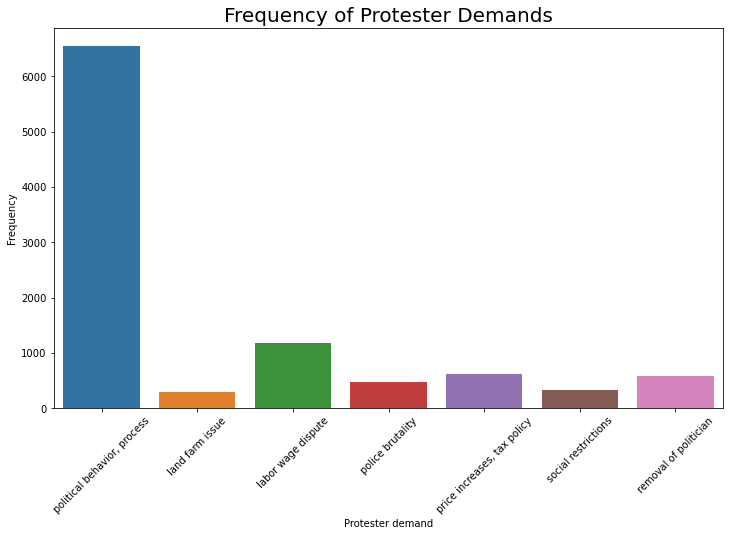

In [ ]:
plt.figure(figsize = (12,7))

sns.countplot(x = social_movements_df["protester_demand"])
plt.xticks(rotation = 45);
plt.title("Frequency of Protester Demands", fontdict = {"fontsize" : 20})
plt.xlabel("Protester demand")
plt.ylabel("Frequency");

<AxesSubplot:ylabel='None'>

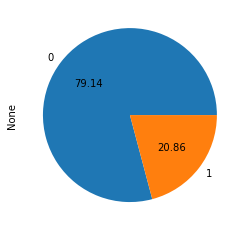

In [ ]:
social_movements_df.groupby("economical_demand").size().plot(kind = "pie", autopct = "%.2f")

In [ ]:
social_movements_df.groupby("protester_demand")["movement_duration"].mean()

protester_demand
labor wage dispute             2.528462
land farm issue                4.523026
police brutality               0.613306
political behavior, process    0.711712
price increases, tax policy    0.682927
removal of politician          0.487136
social restrictions            0.727811
Name: movement_duration, dtype: float64

#### 3.1.2 State Response

In [ ]:
social_movements_df.groupby("state_response").size()

state_response
accomodation        744
arrests             558
beatings            120
crowd dispersal    1875
ignore             6538
killings            109
shootings           103
dtype: int64

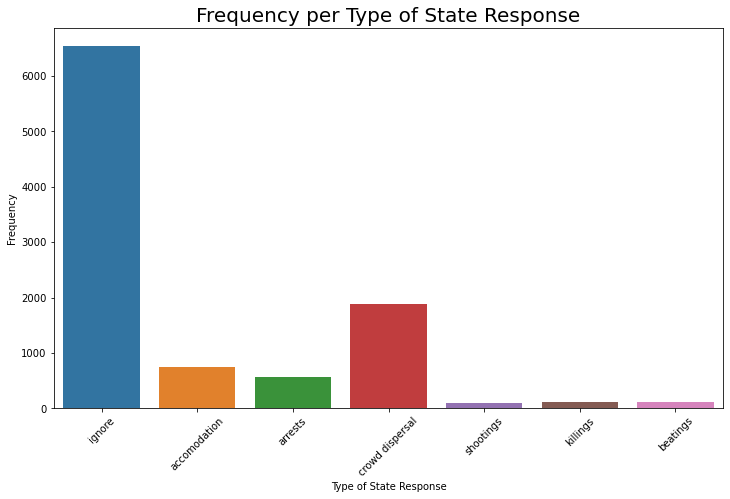

In [ ]:
plt.figure(figsize = (12,7))

sns.countplot(x = social_movements_df["state_response"])
plt.xticks(rotation = 45);
plt.title("Frequency per Type of State Response", fontdict = {"fontsize" : 20})
plt.xlabel("Type of State Response")
plt.ylabel("Frequency");

In [ ]:
social_movements_df.groupby("state_response")["movement_duration"].mean()

state_response
accomodation       4.064516
arrests            1.116487
beatings           0.425000
crowd dispersal    0.640000
ignore             0.781279
killings           1.091743
shootings          1.281553
Name: movement_duration, dtype: float64

In [584]:
social_movements
social_movements = social_movements_df.pivot("protestor_violence", "response_use_force")
ax = sns.heatmap(social_movements)

KeyError: "None of ['protestor_violence'] are in the columns"

### 3.2 Regional Data

In [ ]:
massmob_per_year_northamerica = social_movements_df[social_movements_df["region"] == "North America"].groupby("year").size()
massmob_per_year_centralamerica = social_movements_df[social_movements_df["region"] == "Central America"].groupby("year").size()
massmob_per_year_southamerica = social_movements_df[social_movements_df["region"] == "South America"].groupby("year").size()
massmob_per_year_europe = social_movements_df[social_movements_df["region"] == "Europe"].groupby("year").size()
massmob_per_year_asia = social_movements_df[social_movements_df["region"] == "Asia"].groupby("year").size()
massmob_per_year_mena = social_movements_df[social_movements_df["region"] == "MENA"].groupby("year").size()
massmob_per_year_africa = social_movements_df[social_movements_df["region"] == "Africa"].groupby("year").size()


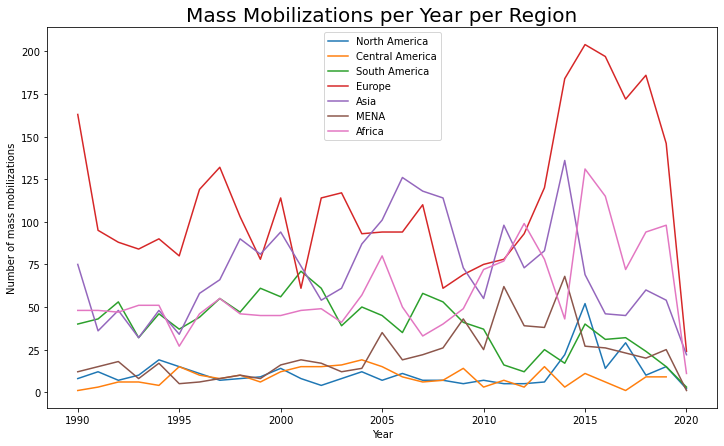

In [ ]:
plt.figure(figsize = (12,7))

plt.plot(massmob_per_year_northamerica.index, massmob_per_year_northamerica, label = "North America")
plt.plot(massmob_per_year_centralamerica.index, massmob_per_year_centralamerica, label = "Central America")
plt.plot(massmob_per_year_southamerica.index, massmob_per_year_southamerica, label = "South America")
plt.plot(massmob_per_year_europe.index, massmob_per_year_europe, label = "Europe")
plt.plot(massmob_per_year_asia.index, massmob_per_year_asia, label = "Asia")
plt.plot(massmob_per_year_mena.index, massmob_per_year_mena, label = "MENA")
plt.plot(massmob_per_year_africa.index, massmob_per_year_africa, label = "Africa")
plt.legend()
plt.title("Mass Mobilizations per Year per Region", fontdict = {"fontsize" : 20});
plt.ylabel("Number of mass mobilizations");
plt.xlabel("Year");

<AxesSubplot:xlabel='region', ylabel='count'>

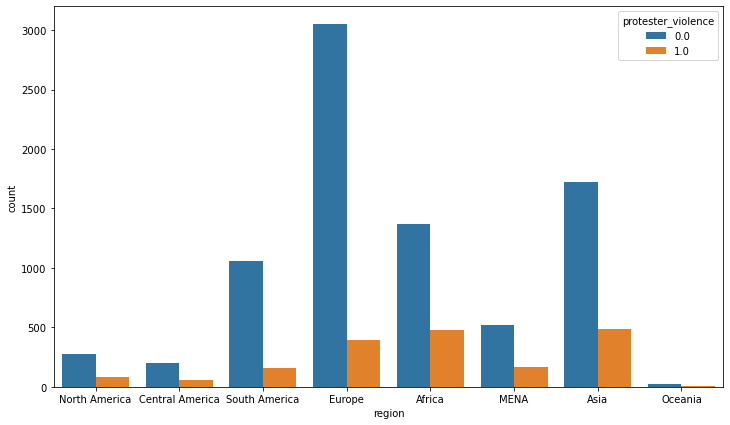

In [ ]:
plt.figure(figsize = (12,7))
sns.countplot(x = social_movements_df["region"], hue = social_movements_df["protester_violence"])

<AxesSubplot:xlabel='region', ylabel='count'>

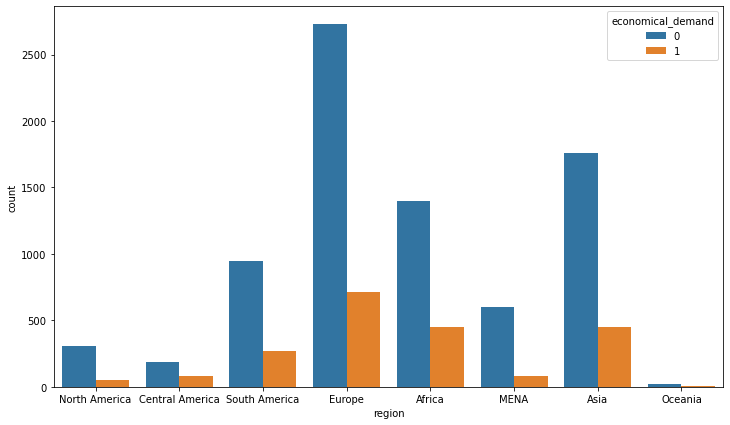

In [ ]:
plt.figure(figsize = (12,7))
sns.countplot(x = social_movements_df["region"], hue = social_movements_df["economical_demand"])

<AxesSubplot:xlabel='region', ylabel='count'>

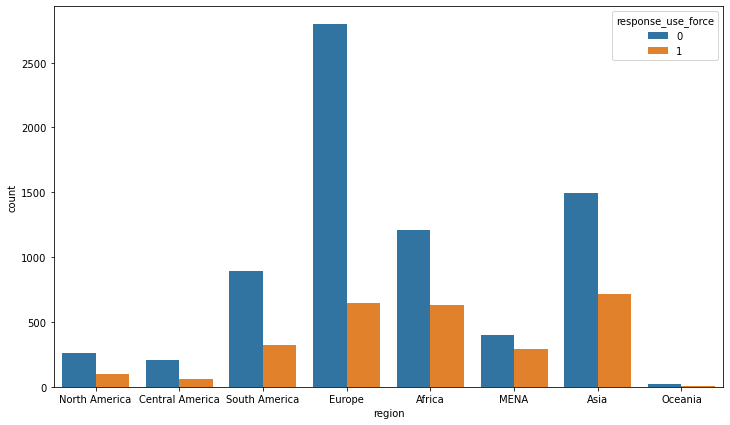

In [ ]:
plt.figure(figsize = (12,7))
sns.countplot(x = social_movements_df["region"], hue = social_movements_df["response_use_force"])

In [ ]:
social_movements_df.groupby("region")["movement_duration"].mean()

region
Africa             0.229686
Asia               1.091814
Central America    1.295455
Europe             0.611693
MENA               1.109649
North America      1.676966
Oceania            0.034483
South America      2.967186
Name: movement_duration, dtype: float64

## 4. Machine Learning

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    social_movements_df[["movement_duration", "year", "protester_violence", "economical_demand"]], social_movements_df["response_use_force"], test_size = 0.25, random_state = 0)


In [ ]:
logistic = linear_model.LogisticRegression()

logistic.fit(X_train, y_train)

LogisticRegression()

In [ ]:
logistic.score(X_test, y_test)

0.8152866242038217

<AxesSubplot:>

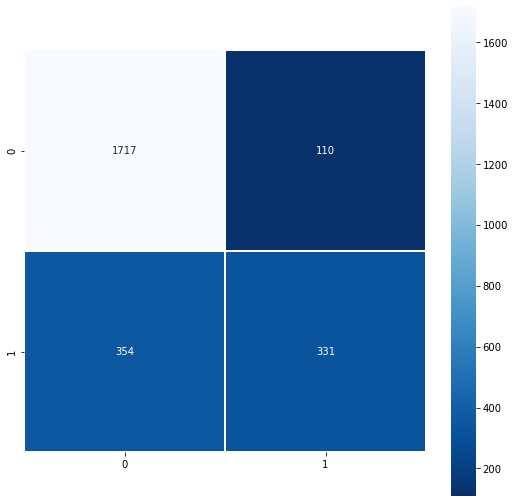

In [ ]:
predictions = logistic.predict(X_test)
conf_matr = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize = (9,9))
sns.heatmap(conf_matr, annot = True, fmt = "d", linewidth = .5, square = True, cmap = "Blues_r")

## 5. Conclusions